In [2]:
import os
import numpy as np
np.random.seed(420)
from IPython.display import HTML
from datetime import datetime
import pickle

from HMM import unsupervised_HMM, from_hmm, HiddenMarkovModel
from HMM_helper import (
    parse_seqs,
    parse_text,
    update_syll_map,
    sample_sentence,
    visualize_sparsities,
    rhyme_dict_gen,
    obs_map_reverser
)
import re, string, nltk

In [3]:
def parse_lim(text, by = 'line', cap='lower', \
               punc_to_drop=re.sub(r"[-']", '', string.punctuation)):
    '''
    Parse a text into a sequence of either sonnets, stanzas, or lines.
    Also handle punctuation and capitalization issues
    '''
    # Issues: tokenize as words? Maybe should have some bigrams / word pairs, etc?
    #         just dropping the weird length sonnets, is there better soln?
    
    if punc_to_drop:
        text = text.translate(str.maketrans('', '', punc_to_drop))
    if cap == 'lower':
        text = text.lower()
        
    limericks = text.split('\n\n')
    # 98 and 125 are NOT 14 line sonnets (15 and 12 resp.)
    limericks = [s for s in limericks if len(s.split('\n')) == 5]
    lines = [l.strip() for s in limericks for l in s.split('\n')]
    
    if by == 'line':
        seqs = lines
    elif by == 'limerick':
        seqs = [' '.join(lines[i:i+5]) for i in range(0, len(lines), 5)]
        
    return seqs

In [4]:
def from_hmm_lim(hmm, obs_map, syll_map=None, rhyme_dict=None):
    '''Make a shakespeare hmm from an hmm '''
    lim_hmm = Lim_HMM(hmm.A, hmm.O, obs_map, syll_map, rhyme_dict)        
    return lim_hmm


class Lim_HMM(HiddenMarkovModel):
    '''
    Class implementation of Shakespeare Hidden Markov Models.
    '''
    def __init__(self, A, O, obs_map, syll_map=None, rhyme_dict=None):
        '''
        Initializes a Shakespeare HMM, inherits from HMMs,
        but also store a syll_map and a rhyming pairs dictionary,
        override the typical generate emission function with
        one that tries to enforce iambic pentameter
        '''
        super().__init__(A, O)
        self.syll = syll_map
        self.rhyme = rhyme_dict
        self.ind_to_word = obs_map_reverser(obs_map)

    def to_word(self, emission):
        sentence = ' '.join([self.ind_to_word[i] for i in emission]).capitalize()
        return sentence + ','

    # p(a | b) propto p(b | a) * p(a), p(a) comes from invariant, p(b | a)
    # is just the A matrix at ab.
    def gen_line(self, backward=False, seed_state=None,
                 syll_count=10, get_states=False, as_word=True):
        ''' Get a single line of syll_count syllables '''

        A = self.A
        if backward:
            A = (self.A.T * self.A_start[None, :]); A /= A.sum(axis=1)[:, None]
        pi = A[seed_state] if seed_state else self.A_start 
        emission = []
        states = []
 
        states.append(np.random.choice(self.L, p = pi))
        remain = syll_count
        while remain != 0:
            curr_state = states[-1]
            pred = lambda l: min(l) <= remain
            inds = np.array([i for i in range(self.D) if pred(self.syll[i])])
            p = self.O[curr_state, inds]; p /= np.sum(p)
            ind = np.random.choice(inds, p = p)
            emission.append(ind)
            l = self.syll[ind]
            count_decrement = l.min() if l.min() <= remain else remain
            remain -= count_decrement
            states.append(np.random.choice(self.L, p = A[curr_state]))
        states.pop()
        if backward:
            emission = emission[::-1]; states = states[::-1]
 
        emission = emission if not as_word else self.to_word(emission)
        return (emission, states) if get_states else emission
    

    def gen_rhyme_n(self, n, syllables):                                                       
        '''                                                                    
        Generate a pair of iambic pentameter lines that rhyme                  
        '''                                                                    
        # Get random line ending with word that rhymes with stuff
        seed1 = np.random.choice(list(self.rhyme.keys()))
        syll1 = self.syll[seed1].min()
        seed_state1 = np.argmax(self.O[:, seed1] * self.A_start)
        line1 = self.gen_line(syll_count=syllables-syll1, backward=True, 
                              seed_state=seed_state1, as_word=False)
        line1.append(seed1)
        lines = [self.to_word(line1)]
        # Get second line using word rhyming with 1st line
        for i in range(n - 1):
            seed2 = np.random.choice(self.rhyme[seed1])
            syll2 = self.syll[seed2].min()
            seed_state2 = np.argmax(self.O[:, seed2] * self.A_start)
            line2 = self.gen_line(syll_count=syllables-syll2, backward=True, 
                                  seed_state=seed_state2, as_word=False)
            line2.append(seed2)
            lines.append(self.to_word(line2))
        return lines
                                                                               
    def generate_limerick(self):
        ''' Get a sonnet with n_lines lines '''
        main = self.gen_rhyme_n(3, 7)
        coup = self.gen_rhyme_n(2, 5)
        limerick = [main[0], main[1], coup[0], coup[1], main[2]]
        return '\n'.join(limerick)

In [5]:
def rhyme_dict_lim(text, sonnet_l=14, abab_pattern_l=12,
                    connected=False, with_words = False): 
    '''
    Generate a rhyming dictionary.
    '''
    lines = parse_lim(text, by='line')                                         
    seqs, obs_map = parse_seqs(lines)
    ind_to_word = obs_map_reverser(obs_map)
                                                                                
    main = [seqs[i+offset][-1] for i in range(0, len(seqs), 5)               
                                for offset in [0, 1, 4]]            
    coup = [seqs[i+offset][-1] for i in range(0, len(seqs), 5)               
                                for offset in [2, 3]]
    
    pair_ends = list(np.ravel([[(a,b),(b,c),(c,a)] for (a,b,c) in np.array(main).reshape(-1, 3)]))
    pair_ends += coup                               
    pairs = list(zip(pair_ends[::2], pair_ends[1::2]))                          
                                                                                
    if connected:
        eq_classes = []
        for (w1, w2) in pairs:
            already_added = False
            for c in eq_classes:
                if w1 in c or w2 in c:
                    c.add(w1); c.add(w2)
                    already_added = True
                    break
            if not already_added:
                c = set(); c.add(w1); c.add(w2)
                eq_classes.append(c)
        d = {w:np.array(list(c)) for c in eq_classes for w in c}
        
    else:
        # Only use rhyming pairings shakespeare specified
        d = {}                                                                      
        for (w1, w2) in pairs:                                                      
            if w1 not in d:                                                         
                d[w1] = []                                                          
            if w2 not in d:                                                         
                d[w2] = []
            d[w1] += [w2] if w2 not in d[w1] else [] 
            d[w2] += [w1] if w1 not in d[w2] else []                             
    
        d = {k:np.unique(v) for k, v in d.items()}
    d_with_words = {ind_to_word[w1] : np.array([ind_to_word[w2] for w2 in v])    
                                      for w1, v in d.items()}                                                                       
    return d_with_words if with_words else d

In [6]:
with open(os.path.join(os.getcwd(), 'data/shakespeare.txt'), 'r') as f:
    text = f.read()

with open(os.path.join(os.getcwd(), 'data/Syllable_dictionary.txt'), 'r') as f:
    syll_map0 = {}
    for i, line in enumerate(f):
        line = line.strip().split()
        word = line[0] 
        # Add 10 to denote end of line syll_count
        sylls = np.array([int(s.replace('E', '1')) for s in line[1:]])
        assert(word not in syll_map0)
        syll_map0[word] = sylls

with open(os.path.join(os.getcwd(), 'data/limericks.txt'), 'r') as f:
    limericks = f.read()

In [7]:
def get_syll_map(words):
    arpabet = nltk.corpus.cmudict.dict()
    counter = lambda l: sum([any([(d in w) for d in string.digits]) for w in l])
    mapper = {w : list(set(counter(pron) for pron in arpabet[w])) \
                  for w in words if w in arpabet}
    bad_words = [w for w in words if w not in arpabet]
    return mapper, bad_words

l_seqs = parse_lim(limericks, by='line')
l_obs, l_obs_map = parse_seqs(l_seqs)
m, bad_words = get_syll_map(l_obs_map.keys())
m2 = {l_obs_map[w]: np.array(sylls) for w,sylls in m.items()}
for word in bad_words:
    sylls = len(word) // 3
    m2[l_obs_map[word]] = np.array([sylls])

In [8]:
l_syll_map = m2
l_rhyme_d = rhyme_dict_lim(limericks, connected=False, with_words=False)
l_hmm8 = unsupervised_HMM(10, l_obs, 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.47s/it]


In [9]:
fName = datetime.today().strftime('%y%m%d_%H%M') + f"_l_hmm{lhmm.L}.pkl"
with open(fName, 'wb') as f:
    pickle.dump(l_hmm8, f)

NameError: name 'lhmm' is not defined

In [12]:
unsupervised_HMM?

In [123]:
with open('200312_2250_l_hmm10.pkl', 'rb') as f:
    l_hmm_g = pickle.load(f)

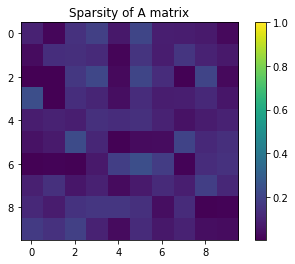

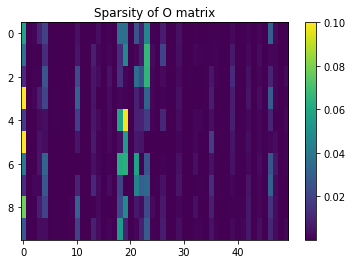

In [31]:
visualize_sparsities(l_hmm8, O_max_cols=50)

In [11]:
print('Sample Sentence:\n====================')
print(sample_sentence(l_hmm8, l_obs_map, n_words=25))

Sample Sentence:
On of an her -- in am her wife pill it for since the had can too ms a even not friend pudenda so fall...


In [15]:
lhmm = from_hmm_lim(l_hmm8, l_obs_map, m2, rhyme_dict=l_rhyme_d)
print(lhmm.generate_limerick())

Young fellow our found she inich,
Couch wanted miners greenwich,
Of you was moxie,
Steam all biloxi,
Have said column young spinach,
